### Importing libraries

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, shutil
import cv2
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import imutils
from sklearn.utils import shuffle

### Formatting dataset

In [37]:
folder = 'Dataset/brain_tumor_dataset/yes/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "Y_" + str(count) + ".jpg"
    os.rename(source, destination)
    count += 1
print("All files are renamed in the yes dir.")

All files are renamed in the yes dir.


In [38]:
folder = 'Dataset/brain_tumor_dataset/no/'
count = 1

for filename in os.listdir(folder):
    source = folder + filename
    destination = folder + "N_" + str(count) + ".jpg"
    os.rename(source, destination)
    count += 1
print("All files are renamed in the no dir.")

All files are renamed in the no dir.


### Exploratory Data Analysis

In [39]:
yes_labels = os.listdir('Dataset/brain_tumor_dataset/yes/')
count_yes_labels = len(yes_labels)

no_labels = os.listdir('Dataset/brain_tumor_dataset/no/')
count_no_labels = len(no_labels)

print(count_yes_labels, count_no_labels)

155 98


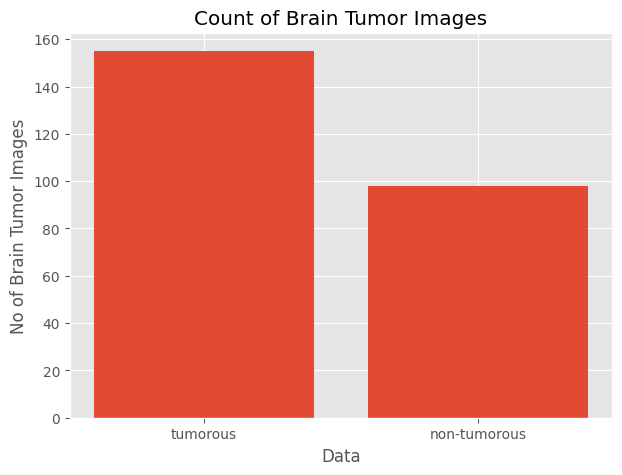

In [40]:
# Visulaizing the distribution of labels
data = {'tumorous': count_yes_labels, 'non-tumorous': count_no_labels}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(7,5))

plt.bar(typex, values)

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

### Data Augmentation

In [41]:
def timing(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int(sec_elapsed % (60 * 60) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{s}"

In [42]:
def augment_data(file_dir, n_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10, 
                      width_shift_range=0.1,
                      height_shift_range=0.1,
                      shear_range=0.1,
                      brightness_range=(0.3, 1.0),
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='nearest')
    
    for filename in os.listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i = 0
        for batch in data_gen.flow(x = image, batch_size = 1, save_to_dir = save_to_dir, save_prefix = save_prefix, save_format = "jpg"):
            i += 1
            if i > n_samples:
                break

In [46]:
import time
start_time = time.time()

yes_path = 'Dataset/brain_tumor_dataset/yes' 
no_path = 'Dataset/brain_tumor_dataset/no'

augmented_data_path = 'Dataset/augmented_data/'

augment_data(file_dir = yes_path, n_samples = 6, save_to_dir = augmented_data_path + 'yes')
augment_data(file_dir = no_path, n_samples = 9, save_to_dir = augmented_data_path + 'no')

end_time = time.time()
execution_time = end_time - start_time
print(timing(execution_time))

0:0:38.56848502159119


In [47]:
# Data Summary
def data_summary(main_path):
    yes_path = "Dataset/augmented_data/yes/" 
    no_path = "Dataset/augmented_data/no/"
    
    n_pos = len(os.listdir(yes_path))
    n_neg = len(os.listdir(no_path))
    
    n = (n_pos + n_neg)
    
    pos_per = (n_pos * 100) / n
    neg_per = (n_neg * 100) / n
    
    print(f"Number of sample: {n}")
    print(f"{n_pos} Number of positive sample in percentage: {pos_per}%")
    print(f"{n_neg} Number of negative sample in percentage: {neg_per}%")

data_summary(augmented_data_path)

Number of sample: 2065
1085 Number of positive sample in percentage: 52.54237288135593%
980 Number of negative sample in percentage: 47.45762711864407%


### Plotting the new dataset

1085 980


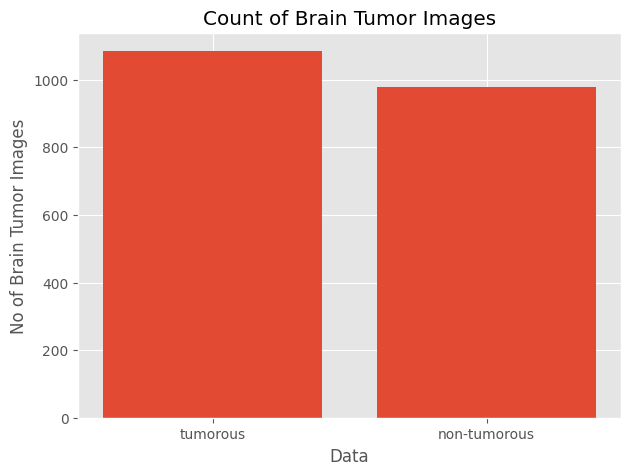

In [48]:
yes_labels = os.listdir('Dataset/augmented_data/yes/')
count_yes_labels = len(yes_labels)

no_labels = os.listdir('Dataset/augmented_data/no/')
count_no_labels = len(no_labels)

print(count_yes_labels, count_no_labels)


# Visulaizing the distribution of labels
data = {'tumorous': count_yes_labels, 'non-tumorous': count_no_labels}

typex = data.keys()
values = data.values()

fig = plt.figure(figsize=(7,5))

plt.bar(typex, values)

plt.xlabel("Data")
plt.ylabel("No of Brain Tumor Images")
plt.title("Count of Brain Tumor Images")
plt.show()

### Data Preprocessing

In [49]:
def processed_image(image, plot=False):
    # Convert BGR to GRAY
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # GuassianBlur
    blur = cv2.GaussianBlur(gray, (5,5), 0)
    # Threshold
    thres = cv2.threshold(blur, 45, 255, cv2.THRESH_BINARY)[1]
    # Erode
    erode =cv2.erode(thres, None, iterations = 2)
    # Dilate
    dilate = cv2.dilate(erode, None, iterations = 2)
    # Find Contours
    cnts = cv2.findContours(dilate.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key = cv2.contourArea)
    
    extLeft = tuple(c[c[:,:,0].argmin()][0])
    extRight = tuple(c[c[:,:,0].argmax()][0])
    extTop = tuple(c[c[:,:,1].argmin()][0])
    extBot = tuple(c[c[:,:,1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] 
    
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        plt.show()
    return new_image

In [50]:
img = cv2.imread('Dataset/augmented_data/yes/aug_Y_1_0_5334.jpg')
res = processed_image(img, True)

[ WARN:0@50858.181] global loadsave.cpp:248 findDecoder imread_('Dataset/augmented_data/yes/aug_Y_1_0_5334.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


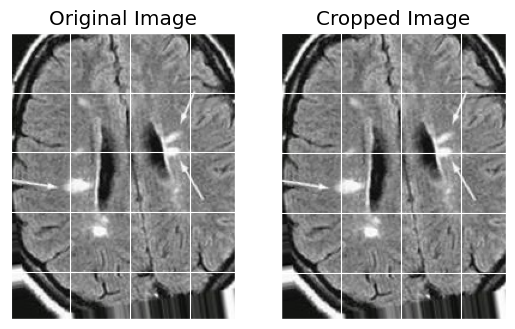

In [24]:
img = cv2.imread('Dataset/augmented_data/no/aug_N_1_0_7835.jpg')
res = processed_image(img, True)

In [54]:
# Preprocessing the entire dataset
# folder1 = 'Dataset/augmented_data/no/'
# folder2 = 'Dataset/augmented_data/yes/'
dir_path = 'Dataset/augmented_data/'

for filename in os.listdir(dir_path + 'no/'):
    img = cv2.imread(dir_path + 'no/' + filename)
    img = processed_image(img, False)
    cv2.imwrite(dir_path + 'no/' + filename, img)
    
for filename in os.listdir(dir_path + 'yes/'):
    img = cv2.imread(dir_path + 'yes/' + filename)
    img = processed_image(img, False)
    cv2.imwrite(dir_path + 'yes/' + filename, img)

In [16]:
# Preparing the datast for training

def load_data(dir_list, image_width, image_height):
    X = []
    y = []
    
    for directory in dir_list:
        for filename in os.listdir(directory):
            image = cv2.imread(directory + '/' + filename)
            image = processed_image(image, plot=False)
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation = cv2.INTER_CUBIC)
            # Normalizing the image pixels
            image = image / 255.0
            X.append(image)
            # Assigning 1 for yes, 0 for no
            if directory[-3 : ] == "yes":
                y.append(1)
            else:
                y.append(0)
    
    X = np.array(X)
    y = np.array(y)

    # Shuffling to prevent model from learning patterns
    X, y = shuffle(X, y)
    print(f"Number of example is : {len(X)}")
    print(f"X SHAPE is : {X.shape}")
    print(f"y SHAPE is : {y.shape}")
    return X, y

In [17]:
augmented_path = 'Dataset/augmented_data/'
augmeneted_yes = augmented_path + 'yes'
augmeneted_no = augmented_path + 'no'

IMAGE_WIDTH, IMAGE_HEIGHT = 240, 240

X,y = load_data([augmeneted_yes, augmeneted_no], IMAGE_WIDTH, IMAGE_HEIGHT)

Number of example is : 2064
X SHAPE is : (2064, 240, 240, 3)
y SHAPE is : (2064,)


In [18]:
# Visualize some preprocessed images
def plot_sample_images(X, y, n=50):
    for label in [0,1]:
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                            labelbottom=False, labeltop=False, labelleft=False,
                            labelright=False)
            i += 1
        
        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()


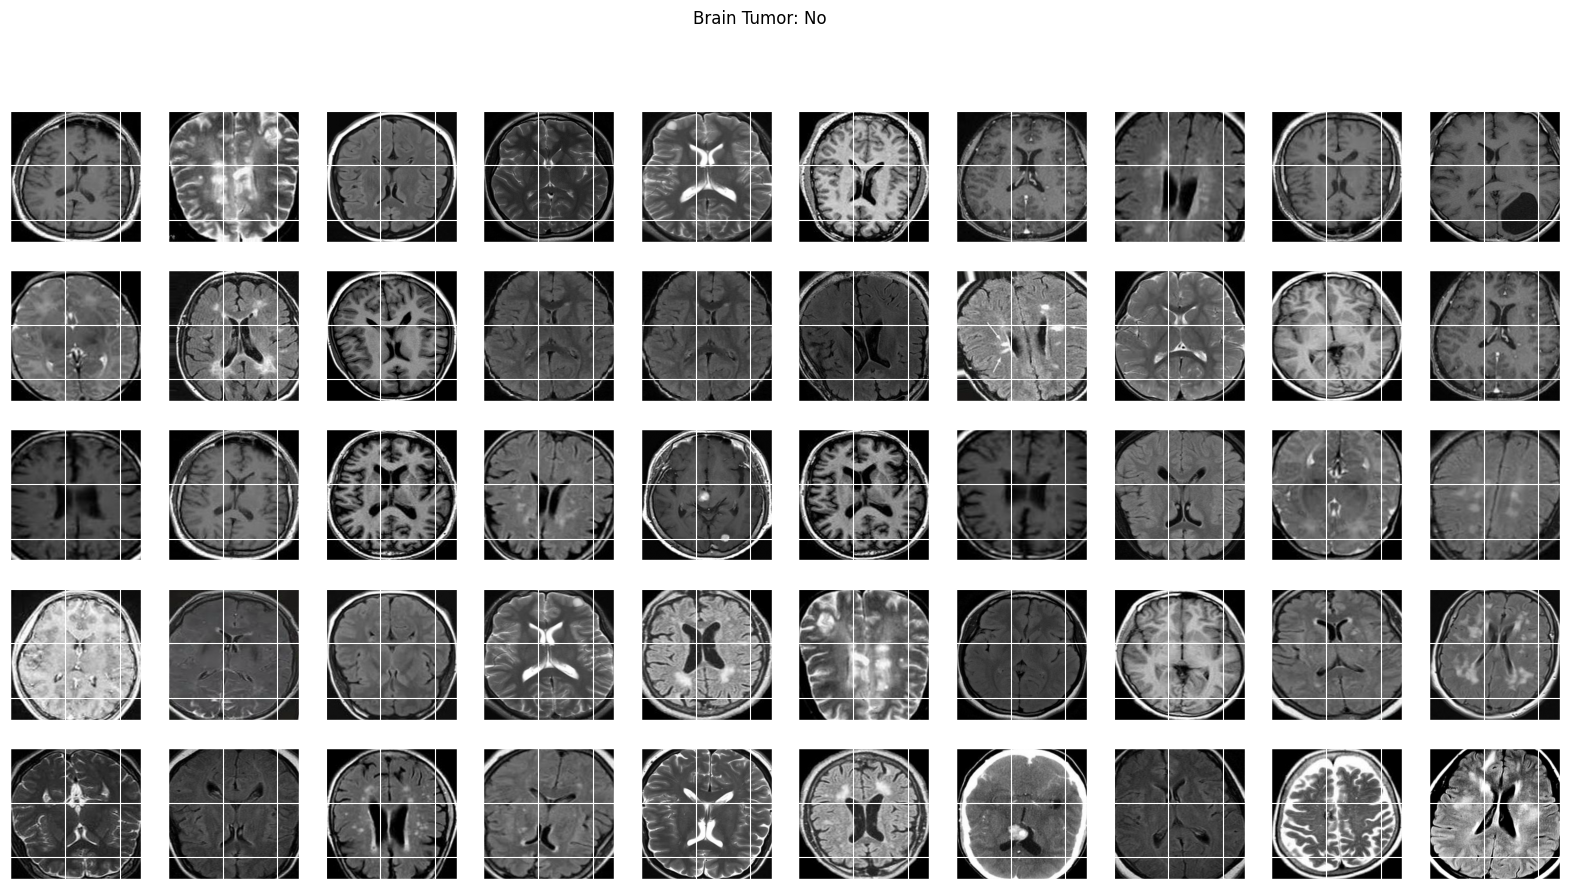

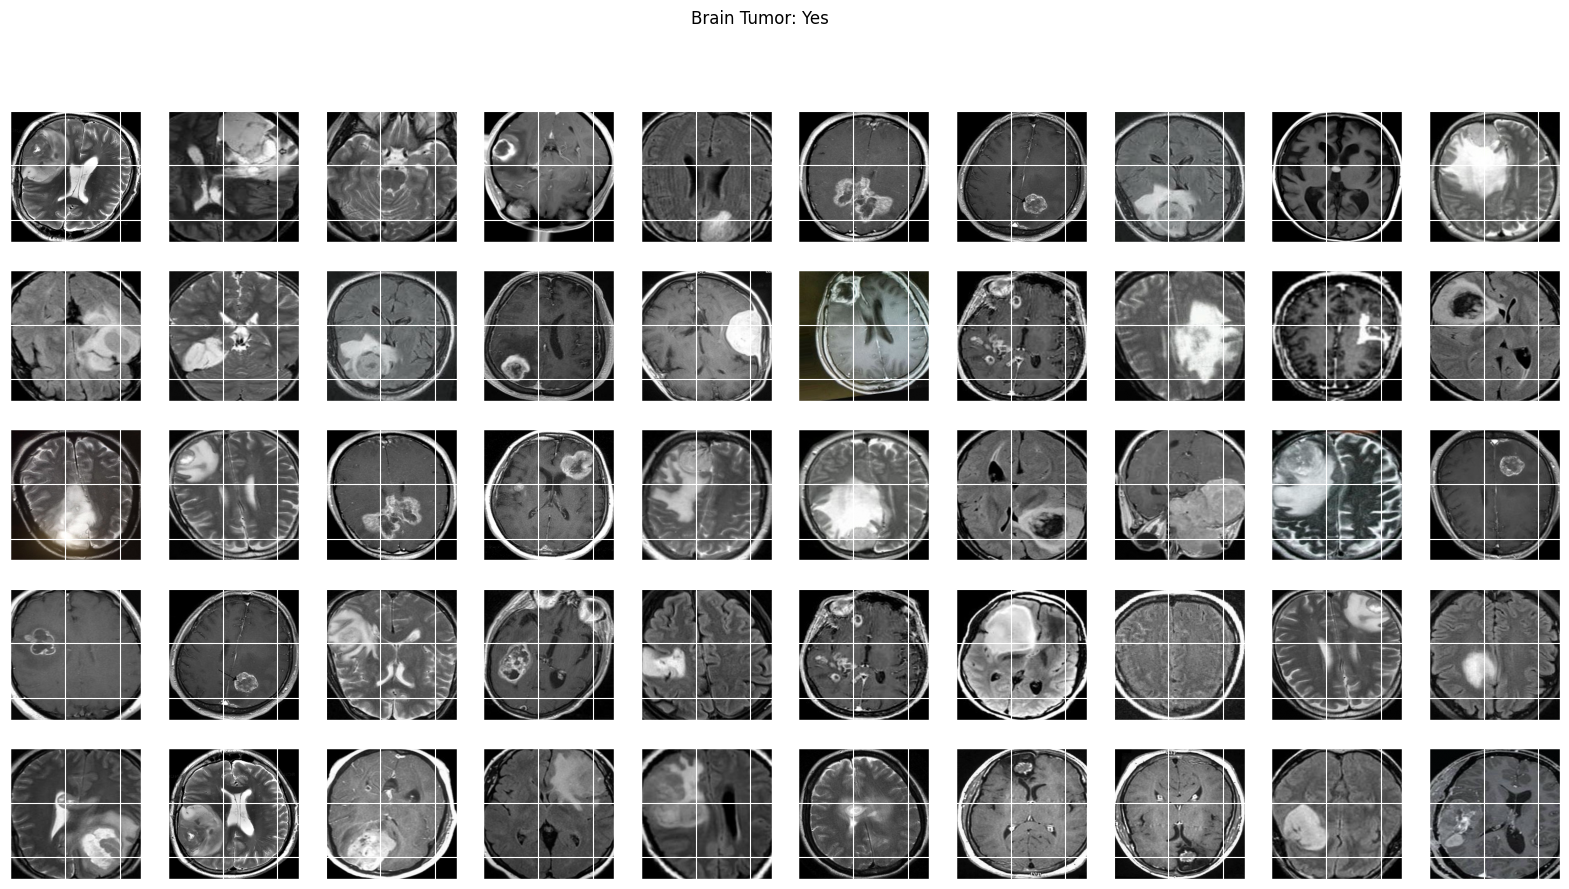

In [19]:
plot_sample_images(X, y)

### Splitting the dataset into train and test set

In [55]:
if not os.path.isdir('processed_data'):
    base_dir = 'Dataset/processed_data'
    os.mkdir(base_dir)


if not os.path.isdir('processed_data/train'):
    train_dir = os.path.join(base_dir , 'train')
    os.mkdir(train_dir)
if not os.path.isdir('processed_data/test'):
    test_dir = os.path.join(base_dir , 'test')
    os.mkdir(test_dir)
if not os.path.isdir('processed_data/valid'):
    valid_dir = os.path.join(base_dir , 'valid')
    os.mkdir(valid_dir)


if not os.path.isdir('processed_data/train/tumorous'):
    infected_train_dir = os.path.join(train_dir, 'tumorous')
    os.mkdir(infected_train_dir)
if not os.path.isdir('processed_data/test/tumorous'):
    infected_test_dir = os.path.join(test_dir, 'tumorous')
    os.mkdir(infected_test_dir)
if not os.path.isdir('processed_data/valid/tumorous'):
    infected_valid_dir = os.path.join(valid_dir, 'tumorous')
    os.mkdir(infected_valid_dir)


if not os.path.isdir('processed_data/train/nontumorous'):
    healthy_train_dir = os.path.join(train_dir, 'nontumorous')
    os.mkdir(healthy_train_dir)
if not os.path.isdir('processed_data/test/nontumorous'):
    healthy_test_dir = os.path.join(test_dir, 'nontumorous')
    os.mkdir(healthy_test_dir)
if not os.path.isdir('processed_data/valid/nontumorous'):
    healthy_valid_dir = os.path.join(valid_dir, 'nontumorous')
    os.mkdir(healthy_valid_dir)

In [56]:
original_dataset_tumorours = os.path.join('Dataset/augmented_data','yes/')
original_dataset_nontumorours = os.path.join('Dataset/augmented_data','no/')

In [57]:
files = os.listdir('Dataset/augmented_data/yes/')
fnames = []
for i in range(0, 758):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_train_dir, fname)
    shutil.copyfile(src, dst)

fnames = []
for i in range(758, 921):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_test_dir, fname)
    shutil.copyfile(src, dst)

fnames = []
for i in range(921, 1084):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_tumorours, fname)
    dst = os.path.join(infected_valid_dir, fname)
    shutil.copyfile(src, dst)

In [58]:
files = os.listdir('Dataset/augmented_data/no/')
fnames = []
for i in range(0, 686):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_train_dir, fname)
    shutil.copyfile(src, dst)

fnames = []
for i in range(686, 833):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_test_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = []
for i in range(833, 979):
    fnames.append(files[i])
for fname in fnames:
    src = os.path.join(original_dataset_nontumorours, fname)
    dst = os.path.join(healthy_valid_dir, fname)
    shutil.copyfile(src, dst)

### Building the model

In [59]:
train_datagen = ImageDataGenerator(rescale = 1.0 / 255,
                  horizontal_flip=0.4,
                  vertical_flip=0.4,
                  rotation_range=40,
                  shear_range=0.2,
                  width_shift_range=0.4,
                  height_shift_range=0.4,
                  fill_mode='nearest')
test_data_gen = ImageDataGenerator(rescale=1.0 / 255)
valid_data_gen = ImageDataGenerator(rescale=1.0 / 255)

In [60]:
train_data = train_datagen.flow_from_directory('Dataset/processed_data/train/', batch_size=32, target_size=(240,240), class_mode='categorical', shuffle=True, seed = 42, color_mode = 'rgb')

Found 1444 images belonging to 2 classes.


In [61]:
test_data = train_datagen.flow_from_directory('Dataset/processed_data/test/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 310 images belonging to 2 classes.


In [62]:
valid_data = train_datagen.flow_from_directory('Dataset/processed_data/valid/', batch_size=32, target_size=(240,240), class_mode='categorical',shuffle=True, seed = 42, color_mode = 'rgb')

Found 309 images belonging to 2 classes.


In [63]:
base_model = VGG19(input_shape = (240,240,3), include_top=False, weights='imagenet')

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_1 = Model(base_model.input, output)
model_1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 120,921,986 (461.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [64]:
filepath = 'model.keras.weights.h5'
ES = EarlyStopping(monitor='val_loss', verbose = 1, mode='min',patience=4)
MCP = ModelCheckpoint(filepath, monitor='val_loss', verbose = 1, save_best_only=True, save_weights_only=True, mode='auto',save_freq='epoch')
LRO_V = ReduceLROnPlateau(monitor='val_accuarcy', patience=3, verbose = 1, factor = 0.5, min_lr = 0.0001)

In [65]:
sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_1.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

/Users/zeerakbabar/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [68]:
model_1_res = model_1.fit(train_data, steps_per_epoch = 10, epochs = 20, callbacks = [ES, MCP, LRO_V], validation_data = valid_data)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5267 - loss: 0.7308
Epoch 1: val_loss improved from 0.69976 to 0.69114, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 71s 7s/step - accuracy: 0.5271 - loss: 0.7307 - val_accuracy: 0.5405 - val_loss: 0.6911 - learning_rate: 1.0000e-04
Epoch 2/20


/Users/zeerakbabar/Library/Python/3.9/lib/python/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuarcy` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5405 - loss: 0.7222
Epoch 2: val_loss did not improve from 0.69114
10/10 ━━━━━━━━━━━━━━━━━━━━ 69s 7s/step - accuracy: 0.5411 - loss: 0.7216 - val_accuracy: 0.4725 - val_loss: 0.7676 - learning_rate: 1.0000e-04
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5740 - loss: 0.7704
Epoch 3: val_loss improved from 0.69114 to 0.63705, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 68s 7s/step - accuracy: 0.5744 - loss: 0.7659 - val_accuracy: 0.6084 - val_loss: 0.6370 - learning_rate: 1.0000e-04
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5248 - loss: 0.6953
Epoch 4: val_loss improved from 0.63705 to 0.61735, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 69s 7s/step - accuracy: 0.5266 - loss: 0.6946 - val_accuracy: 0.7023 - val_loss: 0.6174 - learning_rate: 1.0000e-04
Epoch 5/20
 6/10 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.5168 - loss: 0.6978

2024-04-01 18:13:32.429652: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/contextlib.py:135: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(type, value, traceback)



Epoch 5: val_loss did not improve from 0.61735
10/10 ━━━━━━━━━━━━━━━━━━━━ 53s 5s/step - accuracy: 0.5372 - loss: 0.6522 - val_accuracy: 0.6505 - val_loss: 0.6306 - learning_rate: 1.0000e-04
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5852 - loss: 0.6785
Epoch 6: val_loss did not improve from 0.61735
10/10 ━━━━━━━━━━━━━━━━━━━━ 66s 7s/step - accuracy: 0.5862 - loss: 0.6784 - val_accuracy: 0.6311 - val_loss: 0.6253 - learning_rate: 1.0000e-04
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.5924 - loss: 0.6733
Epoch 7: val_loss improved from 0.61735 to 0.61208, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 67s 7s/step - accuracy: 0.5923 - loss: 0.6728 - val_accuracy: 0.6472 - val_loss: 0.6121 - learning_rate: 1.0000e-04
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6223 - loss: 0.6509
Epoch 8: val_loss did not improve from 0.61208
10/10 ━━━━━━━━━━━━━━━━━━━━ 66s 7s/step - accuracy: 0.6225 - loss: 0.6501 - val_accuracy: 

2024-04-01 18:18:51.153945: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 10: val_loss improved from 0.60503 to 0.60327, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 52s 5s/step - accuracy: 0.5971 - loss: 0.6475 - val_accuracy: 0.6731 - val_loss: 0.6033 - learning_rate: 1.0000e-04
Epoch 11/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6747 - loss: 0.6237
Epoch 11: val_loss improved from 0.60327 to 0.59469, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 68s 7s/step - accuracy: 0.6721 - loss: 0.6250 - val_accuracy: 0.6602 - val_loss: 0.5947 - learning_rate: 1.0000e-04
Epoch 12/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6247 - loss: 0.6525
Epoch 12: val_loss did not improve from 0.59469
10/10 ━━━━━━━━━━━━━━━━━━━━ 63s 7s/step - accuracy: 0.6249 - loss: 0.6524 - val_accuracy: 0.6570 - val_loss: 0.6211 - learning_rate: 1.0000e-04
Epoch 13/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6530 - loss: 0.6268
Epoch 13: val_loss did not improve from 0.59469
10/10 ━━━━━━━━━━━━━━━━━━━━ 65s 7s/step

2024-04-01 18:24:10.056624: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 15: val_loss did not improve from 0.59469
10/10 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - accuracy: 0.5997 - loss: 0.6259 - val_accuracy: 0.6537 - val_loss: 0.6206 - learning_rate: 1.0000e-04
Epoch 15: early stopping


### Plotting Performance

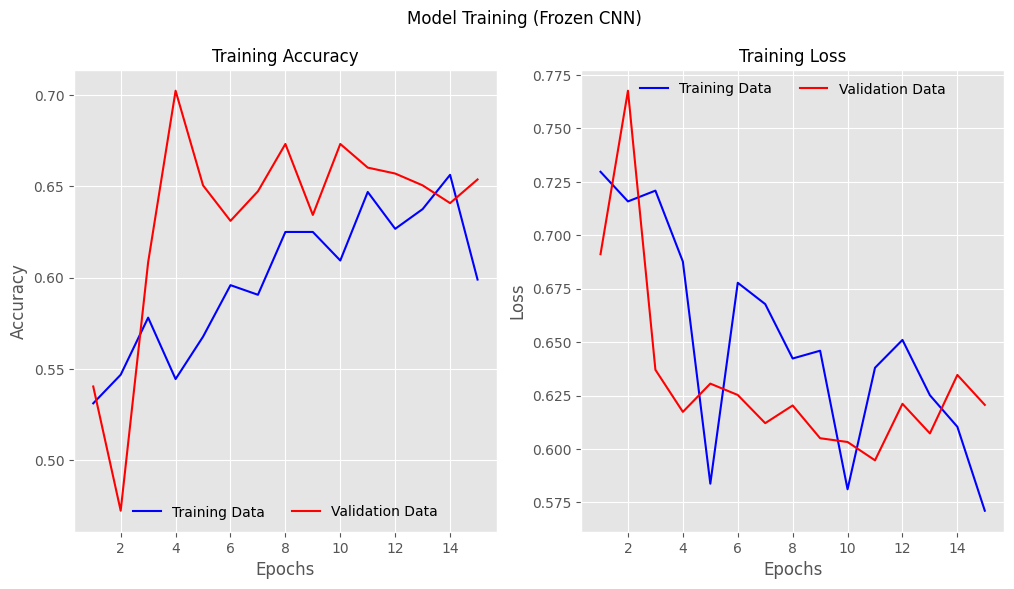

In [69]:
# Plot performance
def plot_performance(stored_model, name):
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
    fig.suptitle("Model Training (Frozen CNN)", fontsize=12)
    max_epoch = len(stored_model.history['accuracy']) + 1
    epochs_list = list(range(1, max_epoch))

    ax1.plot(epochs_list, stored_model.history['accuracy'], color='b', linestyle='-', label='Training Data')
    ax1.plot(epochs_list, stored_model.history['val_accuracy'], color='r', linestyle='-', label='Validation Data')
    ax1.set_title('Training Accuracy', fontsize=12)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(frameon=False, loc='lower center', ncol=2)

    ax2.plot(epochs_list, stored_model.history['loss'], color='b', linestyle='-', label='Training Data')
    ax2.plot(epochs_list, stored_model.history['val_loss'], color='r', linestyle='-', label='Validation Data')
    ax2.set_title('Training Loss', fontsize=12)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(frameon=False, loc='upper center', ncol=2)
    plt.savefig(f"training_{name}_cnn.jpeg", format='jpeg', dpi=100, bbox_inches='tight')

plot_performance(model_1_res, 'model_1')

In [70]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_1.save_weights(filepath="model_weights/vgg19_model_1.keras.weights.h5", overwrite=True)

In [71]:
model_1.load_weights("model_weights/vgg19_model_1.keras.weights.h5")
vgg_val_eval_01 = model_1.evaluate(valid_data)
vgg_test_eval_01 = model_1.evaluate(test_data)

10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.6465 - loss: 0.6101


/Users/zeerakbabar/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.5897 - loss: 0.6697


In [72]:
filenames = test_data.filenames
nb_sample = len(filenames)

vgg_prediction = model_1.predict(test_data, steps=nb_sample, verbose = 1)
y_pred = np.argmax(vgg_prediction, axis=1)

310/310 ━━━━━━━━━━━━━━━━━━━━ 34s 97ms/step


2024-04-01 18:26:57.298309: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
/Applications/Xcode.app/Contents/Developer/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/contextlib.py:135: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(type, value, traceback)


In [73]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers] 
base_model_layer_names

['input_layer_1',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_conv4',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_conv4',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_conv4',
 'block5_pool']

In [80]:
base_model = VGG19(include_top=False, input_shape=(240,240,3))
base_model_layer_names = [layer.name for layer in base_model.layers] 
# base_model_layer_names

x = base_model.output
flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)
drop_out = Dropout(0.2)(class_1)
class_2 = Dense(1152, activation = 'relu')(drop_out)
output = Dense(2, activation = 'softmax')(class_2)

model_2 = Model(base_model.inputs, output)
model_2.load_weights('model_weights/vgg19_model_1.keras.weights.h5')

sgd = SGD(learning_rate=0.0001, decay = 1e-6, momentum = 0.9, nesterov = True)
model_2.compile(loss='categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])
model_2.summary()

/Users/zeerakbabar/Library/Python/3.9/lib/python/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 240, 240, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 240, 240, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 120, 120, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 120, 120, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 120, 120, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 60, 60, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 60, 60, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 30, 30, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 30, 30, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 15, 15, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4608)           │   115,610,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4608)           │             

 Total params: 140,946,370 (537.67 MB)

 Trainable params: 140,946,370 (537.67 MB)

 Non-trainable params: 0 (0.00 B)

In [82]:
model_2_res = model_2.fit(train_data, steps_per_epoch=10, epochs = 50, callbacks=[ES, MCP, LRO_V], validation_data=valid_data)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.6645 - loss: 0.6098 
Epoch 1: val_loss did not improve from 0.58025
10/10 ━━━━━━━━━━━━━━━━━━━━ 152s 15s/step - accuracy: 0.6632 - loss: 0.6099 - val_accuracy: 0.6214 - val_loss: 0.6309 - learning_rate: 1.0000e-04
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6818 - loss: 0.5933 
Epoch 2: val_loss did not improve from 0.58025
10/10 ━━━━━━━━━━━━━━━━━━━━ 139s 14s/step - accuracy: 0.6827 - loss: 0.5927 - val_accuracy: 0.6893 - val_loss: 0.5858 - learning_rate: 1.0000e-04
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6954 - loss: 0.5957 
Epoch 3: val_loss did not improve from 0.58025
10/10 ━━━━━━━━━━━━━━━━━━━━ 144s 15s/step - accuracy: 0.6959 - loss: 0.5953 - val_accuracy: 0.6408 - val_loss: 0.5919 - learning_rate: 1.0000e-04
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6451 - loss: 0.5771 
Epoch 4: val_loss improved from 0.58025 to 0.53186, saving model to model.keras.weig

2024-04-01 18:44:16.449568: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 5: val_loss did not improve from 0.53186
10/10 ━━━━━━━━━━━━━━━━━━━━ 100s 10s/step - accuracy: 0.7101 - loss: 0.5138 - val_accuracy: 0.7152 - val_loss: 0.5503 - learning_rate: 1.0000e-04
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7151 - loss: 0.5580 
Epoch 6: val_loss did not improve from 0.53186
10/10 ━━━━━━━━━━━━━━━━━━━━ 150s 15s/step - accuracy: 0.7145 - loss: 0.5593 - val_accuracy: 0.6537 - val_loss: 0.6009 - learning_rate: 1.0000e-04
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7008 - loss: 0.5810 
Epoch 7: val_loss improved from 0.53186 to 0.50777, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 149s 15s/step - accuracy: 0.7005 - loss: 0.5807 - val_accuracy: 0.7638 - val_loss: 0.5078 - learning_rate: 1.0000e-04
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7531 - loss: 0.5299 
Epoch 8: val_loss improved from 0.50777 to 0.48745, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 140s 1

2024-04-01 18:55:36.027601: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 10: val_loss did not improve from 0.48745
10/10 ━━━━━━━━━━━━━━━━━━━━ 98s 10s/step - accuracy: 0.7065 - loss: 0.5177 - val_accuracy: 0.7799 - val_loss: 0.4995 - learning_rate: 1.0000e-04
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7647 - loss: 0.5132 
Epoch 11: val_loss improved from 0.48745 to 0.46559, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 148s 15s/step - accuracy: 0.7633 - loss: 0.5139 - val_accuracy: 0.8058 - val_loss: 0.4656 - learning_rate: 1.0000e-04
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.7826 - loss: 0.4822 
Epoch 12: val_loss improved from 0.46559 to 0.43449, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 149s 15s/step - accuracy: 0.7834 - loss: 0.4801 - val_accuracy: 0.8350 - val_loss: 0.4345 - learning_rate: 1.0000e-04
Epoch 13/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7036 - loss: 0.5444 
Epoch 13: val_loss did not improve from 0.43449
10/10 ━━━━━━━━━━━━━━━━━━━━ 

2024-04-01 19:07:00.871668: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 15: val_loss did not improve from 0.43449
10/10 ━━━━━━━━━━━━━━━━━━━━ 100s 10s/step - accuracy: 0.7582 - loss: 0.4570 - val_accuracy: 0.7055 - val_loss: 0.5245 - learning_rate: 1.0000e-04
Epoch 16/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8041 - loss: 0.4608 
Epoch 16: val_loss improved from 0.43449 to 0.39125, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 145s 15s/step - accuracy: 0.8037 - loss: 0.4598 - val_accuracy: 0.8350 - val_loss: 0.3912 - learning_rate: 1.0000e-04
Epoch 17/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8324 - loss: 0.4205 
Epoch 17: val_loss improved from 0.39125 to 0.37362, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 148s 15s/step - accuracy: 0.8308 - loss: 0.4203 - val_accuracy: 0.8673 - val_loss: 0.3736 - learning_rate: 1.0000e-04
Epoch 18/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8509 - loss: 0.3803 
Epoch 18: val_loss did not improve from 0.37362
10/10 ━━━━━━━━━━━━━━━━━━━━

2024-04-01 19:18:23.066541: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 20: val_loss improved from 0.37216 to 0.32913, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 102s 10s/step - accuracy: 0.8133 - loss: 0.3878 - val_accuracy: 0.8964 - val_loss: 0.3291 - learning_rate: 1.0000e-04
Epoch 21/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8018 - loss: 0.4365 
Epoch 21: val_loss did not improve from 0.32913
10/10 ━━━━━━━━━━━━━━━━━━━━ 150s 15s/step - accuracy: 0.8014 - loss: 0.4354 - val_accuracy: 0.8188 - val_loss: 0.3626 - learning_rate: 1.0000e-04
Epoch 22/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8684 - loss: 0.3367 
Epoch 22: val_loss did not improve from 0.32913
10/10 ━━━━━━━━━━━━━━━━━━━━ 148s 15s/step - accuracy: 0.8661 - loss: 0.3416 - val_accuracy: 0.8511 - val_loss: 0.3511 - learning_rate: 1.0000e-04
Epoch 23/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8126 - loss: 0.4415 
Epoch 23: val_loss did not improve from 0.32913
10/10 ━━━━━━━━━━━━━━━━━━━━ 138s 14s/step - accuracy: 0.8122 - loss: 0.

2024-04-01 19:29:45.087492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 25: val_loss did not improve from 0.31601
10/10 ━━━━━━━━━━━━━━━━━━━━ 98s 10s/step - accuracy: 0.8397 - loss: 0.3537 - val_accuracy: 0.8414 - val_loss: 0.3542 - learning_rate: 1.0000e-04
Epoch 26/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8760 - loss: 0.3056 
Epoch 26: val_loss did not improve from 0.31601
10/10 ━━━━━━━━━━━━━━━━━━━━ 145s 15s/step - accuracy: 0.8745 - loss: 0.3058 - val_accuracy: 0.7961 - val_loss: 0.4353 - learning_rate: 1.0000e-04
Epoch 27/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8349 - loss: 0.3565 
Epoch 27: val_loss improved from 0.31601 to 0.29112, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 145s 15s/step - accuracy: 0.8354 - loss: 0.3551 - val_accuracy: 0.8867 - val_loss: 0.2911 - learning_rate: 1.0000e-04
Epoch 28/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8984 - loss: 0.2700 
Epoch 28: val_loss improved from 0.29112 to 0.27917, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 

2024-04-01 19:41:03.171561: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 30: val_loss did not improve from 0.27917
10/10 ━━━━━━━━━━━━━━━━━━━━ 102s 10s/step - accuracy: 0.8539 - loss: 0.3351 - val_accuracy: 0.8738 - val_loss: 0.2896 - learning_rate: 1.0000e-04
Epoch 31/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8441 - loss: 0.3403 
Epoch 31: val_loss improved from 0.27917 to 0.27395, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 150s 15s/step - accuracy: 0.8435 - loss: 0.3413 - val_accuracy: 0.8997 - val_loss: 0.2740 - learning_rate: 1.0000e-04
Epoch 32/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8951 - loss: 0.2812 
Epoch 32: val_loss did not improve from 0.27395
10/10 ━━━━━━━━━━━━━━━━━━━━ 149s 15s/step - accuracy: 0.8947 - loss: 0.2809 - val_accuracy: 0.8576 - val_loss: 0.3105 - learning_rate: 1.0000e-04
Epoch 33/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8650 - loss: 0.3158 
Epoch 33: val_loss did not improve from 0.27395
10/10 ━━━━━━━━━━━━━━━━━━━━ 148s 15s/step - accuracy: 0.8665 - loss: 0.

2024-04-01 19:52:24.523944: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 35: val_loss improved from 0.27395 to 0.26664, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 97s 9s/step - accuracy: 0.8831 - loss: 0.2767 - val_accuracy: 0.8770 - val_loss: 0.2666 - learning_rate: 1.0000e-04
Epoch 36/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.8555 - loss: 0.2716 
Epoch 36: val_loss improved from 0.26664 to 0.21312, saving model to model.keras.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 143s 15s/step - accuracy: 0.8575 - loss: 0.2694 - val_accuracy: 0.9126 - val_loss: 0.2131 - learning_rate: 1.0000e-04
Epoch 37/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.8742 - loss: 0.2802 
Epoch 37: val_loss did not improve from 0.21312
10/10 ━━━━━━━━━━━━━━━━━━━━ 149s 15s/step - accuracy: 0.8751 - loss: 0.2791 - val_accuracy: 0.8964 - val_loss: 0.2504 - learning_rate: 1.0000e-04
Epoch 38/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7926 - loss: 0.4745 
Epoch 38: val_loss did not improve from 0.21312
10/10 ━━━━━━━━━━━━━━━━━━━━ 1

2024-04-01 20:03:40.251391: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 40: val_loss did not improve from 0.21312
10/10 ━━━━━━━━━━━━━━━━━━━━ 96s 9s/step - accuracy: 0.9020 - loss: 0.2423 - val_accuracy: 0.8964 - val_loss: 0.2465 - learning_rate: 1.0000e-04
Epoch 40: early stopping


In [83]:
if not os.path.isdir('model_weights/'):
    os.mkdir('model_weights/')
model_2.save_weights(filepath="model_weights/vgg_unfrozen.keras.weights.h5", overwrite=True)

In [84]:
model_2.load_weights("model_weights/vgg_unfrozen.keras.weights.h5")
vgg_val_eval_03 = model_2.evaluate(valid_data)
vgg_test_eval_03 = model_2.evaluate(test_data)

10/10 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.8631 - loss: 0.2878
10/10 ━━━━━━━━━━━━━━━━━━━━ 33s 3s/step - accuracy: 0.8954 - loss: 0.2710


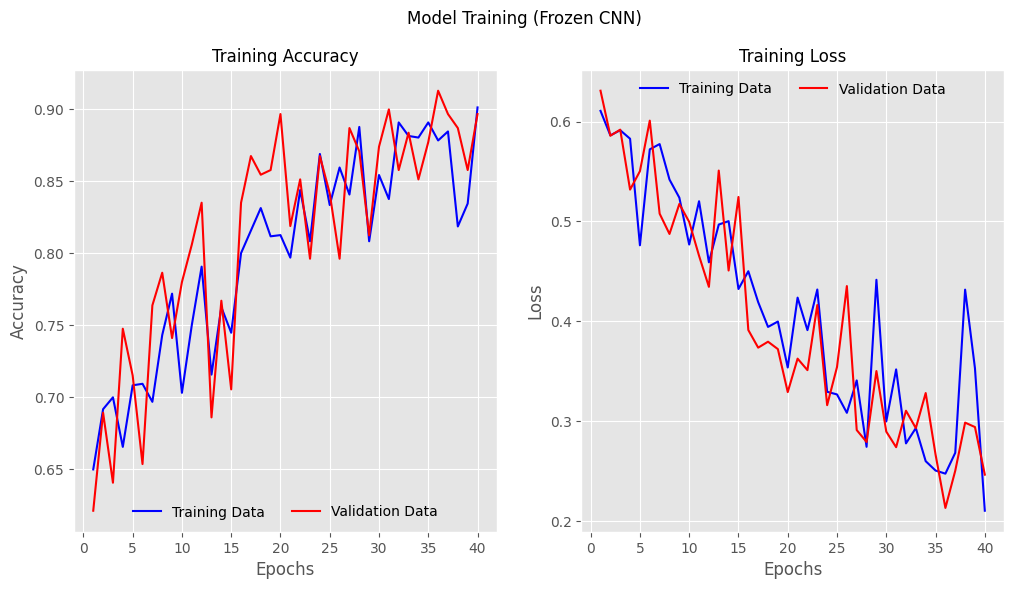

In [85]:
plot_performance(model_2_res, 'model_2')